# Compare TF Statistics across Everest, Fuji, and Guadalupe

In [44]:
from desispec.io import read_spectra, write_spectra
from desispec.spectra import stack as specstack
from desispec.coaddition import coadd_cameras
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution

import redrock.templates

rrtemplates = dict()
for filename in redrock.templates.find_templates():
    t = redrock.templates.Template(filename)
    rrtemplates[(t.template_type, t.sub_type)] = t

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, vstack, hstack, join, unique
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

from datetime import datetime, timedelta

from scipy.ndimage import gaussian_filter1d

import os
from glob import glob

import psycopg2

from tqdm.notebook import tqdm_notebook

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock-templates/master
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


In [2]:
mpl.rc('font', size=14)

In [3]:
def firstdigit(n):
    return np.trunc(n * 10**(-np.trunc(np.log10(n)))).astype(int)

def plot_radec(ra, dec):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    ra : pandas.Series or list
        List of candidate RA [deg].
    dec : pandas.Series or list
        List of candidate Dec [deg].
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    # Convert RA, Dec to radians.
    # Rotate the RA so that the plot goes 360->0 left to right.
    _ra = np.radians(180 - ra)
    _dec = np.radians(dec)

    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    ax.scatter(_ra, _dec, alpha=0.5, s=2)
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    fig.tight_layout()
    
    return fig;

import requests

def get_cutout(targetid, ra, dec, width=300, height=300, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    targetid : int
        DESI target ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    os.makedirs('_cache', exist_ok=True)
    img_name = f'_cache/cutout_{targetid}_{width}_{height}.jpg'
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        if verbose:
            print('Accessing {}'.format(img_name))
        img_url = f'https://www.legacysurvey.org/viewer/cutout.jpg?ra={ra}&dec={dec}&%22/pix=0.25&layer=ls-dr9&width={width}&height={height}&sga'
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.25/3600,
        'CRPIX1': width//2,
        'CRVAL1': ra,
        'NAXIS1': width,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.25/3600,
        'CRPIX2': height//2,
        'CRVAL2': dec,
        'NAXIS2': height
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

## Fuji

In [4]:
tfuji = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')
tfuji

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
1079550234591232,194.390863195343,27.5157211790145,10378,sv3,1.1235686466514,7.31685779475115e-05,4,3.28414569795132,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124544,194.390863195343,27.5157211790145,10378,sv3,0.686773088332363,6.9756676262104e-05,4,0.786607094109058,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.39086319534337,27.51572117901454
1092744374124546,194.364461113654,27.5037185881314,10378,sv3,0.0242933923052181,4.95233472646785e-05,0,95.428411073226,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.36446111365385,27.50371858813136
1092744369930240,194.338458724402,27.4918902690326,10378,sv3,0.0264170223697961,0.00010139452689994,0,9.53278421035066,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.33845872440244,27.491890269032595
1092744374124545,194.377858465028,27.5098100780282,10378,sv3,0.211332646769145,6.68535116703737e-05,4,3.73989077657461,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3778584650283,27.509810078028195
1092744369930241,194.325065734878,27.4857950068364,10378,sv3,0.34112572843082,7.87536530522298e-05,4,5.80425057094544,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3250657348779,27.48579500683636
1079550230396930,194.312068074608,27.4798777913963,10378,sv3,1.43883246626074,0.000118079246392633,4,1.41281921416521,fuji/healpix/sv3/bright/103/10378/redrock-sv3-bright-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1092744369930242,194.312068074608,27.4798777913963,10378,sv3,0.141836800089955,6.14844128636576e-05,4,8.01571118086576,fuji/healpix/sv3/dark/103/10378/redrock-sv3-dark-10378.fits,EXT,662902,194.3120680746076,27.479877791396284
1080141245579266,268.972484124775,62.5902888954075,10207,sv3,1.25885927887654,0.000161730072763419,4,4.86104696989059,fuji/healpix/sv3/bright/102/10207/redrock-sv3-bright-10207.fits,EXT,674212,268.972484124775,62.59028889540747


### Targets grouped by SGA_ID

Find all targets with at least 2 observations per SGA_ID.

In [5]:
# All targets
_ids_all, _counts_all = np.unique(tfuji['SGA_ID'], return_counts=True)

# All targets with decent redshifts
isgoodz = (tfuji['ZWARN']==0) & (tfuji['DELTACHI2']>=25)
_ids_goodz, _counts_goodz = np.unique(tfuji['SGA_ID'][isgoodz], return_counts=True)
_ids_goodz[_counts_goodz > 1]

848
896
1548
1583
1980
2497
3727
5732
5958
5964
6443


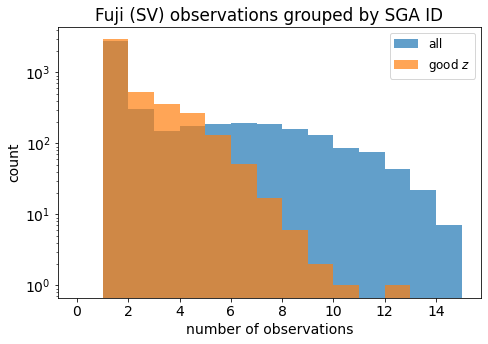

In [6]:
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)
ax.hist(_counts_all, bins=np.arange(0,16), alpha=0.7, log=True, label='all')
ax.hist(_counts_goodz, bins=np.arange(0,16), alpha=0.7, log=True, label='good $z$')
ax.set(xlabel='number of observations',
       ylabel='count',
       title='Fuji (SV) observations grouped by SGA ID')
ax.legend(fontsize=12, loc='upper right');

In [7]:
select = np.in1d(tfuji['SGA_ID'], _ids_goodz[_counts_goodz > 1]) & isgoodz
tfuji_tf = tfuji[select].group_by('SGA_ID')
tfuji_tf

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes3,float64,float64,int64,float64,bytes63,bytes3,int64,float64,float64
39628433264739393,194.449890288551,27.7265501585086,10400,sv1,0.0699433547367303,9.06362424382781e-06,0,14655.6281126067,fuji/healpix/sv1/bright/104/10400/redrock-sv1-bright-10400.fits,SGA,848,194.44989028855093,27.726550158508566
39628433264739393,194.449890288551,27.7265501585086,10400,sv3,0.0699116031710255,2.72330650976674e-05,0,1722.94172295742,fuji/healpix/sv3/bright/104/10400/redrock-sv3-bright-10400.fits,SGA,848,194.44989028855093,27.726550158508566
39627817951955633,180.381827027663,1.29582683075782,27649,sv3,0.0224279674032048,2.44404472261522e-05,0,283.560888532142,fuji/healpix/sv3/bright/276/27649/redrock-sv3-bright-27649.fits,TFT,896,180.38182702766252,1.2958268307578154
1070144189104132,180.383498876859,1.29621479718706,27649,sv3,0.0222944544366663,2.83413346431536e-05,0,45.697032826487,fuji/healpix/sv3/bright/276/27649/redrock-sv3-bright-27649.fits,TFT,896,180.38349887685897,1.2962147971870641
39632941722111933,252.860799700982,33.0343044855604,9337,sv3,0.0621058276441731,7.86988716030476e-06,0,996.112674765289,fuji/healpix/sv3/bright/93/9337/redrock-sv3-bright-9337.fits,TFT,1548,252.86079970098154,33.03430448556036
1070869912748034,252.860062744453,33.03565124542,9337,sv3,0.0625669112434631,7.42303672319939e-06,0,437.830720379949,fuji/healpix/sv3/bright/93/9337/redrock-sv3-bright-9337.fits,TFT,1548,252.86006274445305,33.035651245420034
1071077795037187,236.813448650733,43.9957553864163,9923,sv3,0.0352887795291414,7.31620291911626e-06,0,550.152345106006,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.8134486507333,43.99575538641631
1084271934570499,236.813448650733,43.9957553864163,9923,sv3,0.0353008322684175,9.4825361822116e-06,0,335.291149647906,fuji/healpix/sv3/dark/99/9923/redrock-sv3-dark-9923.fits,TFT,1583,236.8134486507333,43.99575538641631
1071077795037186,236.810202992035,43.9950609278788,9923,sv3,0.0356212945166845,2.64003527378348e-05,0,36.7676933435723,fuji/healpix/sv3/bright/99/9923/redrock-sv3-bright-9923.fits,TFT,1583,236.81020299203462,43.99506092787884


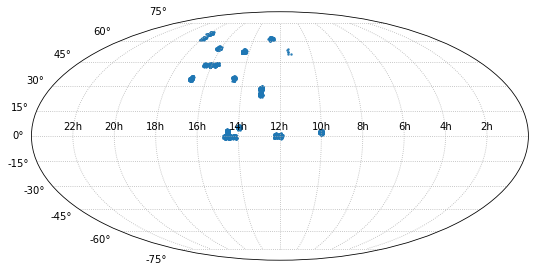

In [8]:
fig = plot_radec(tfuji_tf['TARGET_RA'], tfuji_tf['TARGET_DEC'])

In [9]:
np.sum(firstdigit(tfuji_tf['TARGETID']) == 3)

1439

### Loop through Observations of SGA Objects

sga_ids = np.unique(tfuji_tf['SGA_ID'])
N = len(sga_ids)

with tqdm_notebook(total=N) as progress_bar:
    for i, sga_id in enumerate(sga_ids):
        progress_bar.update(1)
        
        tab = tfuji_tf[tfuji_tf['SGA_ID']==sga_id]

        # Grab TARGETIDs starting with 3, which is probably the MAIN (SGA) target.
        digits = firstdigit(tab['TARGETID'])
        if np.any(digits == 3):
            maintargetids = np.unique(tab['TARGETID'][digits==3].value)
        else:
            print(f'No MAIN (SGA) target for {sga_id}?')
            continue

        # For now, just grab the first TARGETID in the list that is assumed to be the galaxy center
        maintargetid = maintargetids[0]
        mainobs = tab[tab['TARGETID']==maintargetid][0]
        ra, dec, z = [mainobs[_] for _ in ['RA', 'DEC', 'Z']]

        # Download the corresponding image file.
        npix=380
        img_file, img_wcs = get_cutout(maintargetid, ra=ra, dec=dec, width=npix, height=npix, verbose=False)
        img = plt.imread(img_file)
        img = img[:, :, :3].mean(axis=2)

        # Draw the object and the positions of all observations.
        fig = plt.figure(num=1, figsize=(6.5,5), clear=True)
        ax1 = fig.add_subplot(111, projection=img_wcs)
        ax1.imshow(np.flip(img**1.7, axis=0), cmap='gray_r')
        ax1.set(xlabel=r'right ascension $\alpha$',
                ylabel=r'declination $\delta$')
        ax1.text(int(0.02*npix), int(0.85*npix),
                 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(maintargetid, sga_id, z),
                 fontsize=9,
                 color='red')

        for obs in tab:
            ra, dec = [obs[_] for _ in ['RA', 'DEC']]
            for color, lw in zip(['white', 'black'], [4, 1]):
                r = SphericalCircle((ra*u.deg, dec*u.deg), 1.5*u.arcsec,
                                 edgecolor=color, facecolor='none', alpha=0.8, lw=lw, ls='-',
                                 transform=ax1.get_transform('icrs'))
                ax1.add_patch(r)

        fig.savefig(f'_cache/pv_tv_fuji_{maintargetid}.png', dpi=120)

## Guadalupe

### Main survey only

In [33]:
tguad = Table.read('/global/project/projectdirs/desi/science/td/pv/desi_pv_tf_guadalupe_healpix.fits')
tguad = unique(tguad[tguad['SURVEY']=='main'])
# tguad = tguad[tguad['SURVEY']=='main']
tguad

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes7,float64,float64,int64,float64,bytes76,bytes3,int64,float64,float64
-211637396,214.408367861604,38.1654319218372,10550,main,-0.00199569129234795,4.13114935733491e-48,3618,1.94266889222573e+84,guadalupe/healpix/main/bright/105/10550/redrock-main-bright-10550.fits,TFT,908460,214.40820991032487,38.1654315747636
-205733115,193.87126208164,-7.79797192944254,25775,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/bright/257/25775/redrock-main-bright-25775.fits,EXT,1232665,193.8711697701549,-7.797829020837202
-204141114,256.286226415617,7.99070771912205,31568,main,-0.00199569129234795,4.13114935733491e-48,3618,1.94266889222573e+84,guadalupe/healpix/main/bright/315/31568/redrock-main-bright-31568.fits,SGA,1127864,256.2861272736802,7.990563879458973
-21951418,216.243322559367,35.3508295804599,10515,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/dark/105/10515/redrock-main-dark-10515.fits,TFT,1287197,216.24324832697206,35.350942322499904
-21637396,214.408354412019,38.1654094359474,10550,main,-0.00199569129234795,4.13114935733491e-48,3618,1.94266889222573e+84,guadalupe/healpix/main/dark/105/10550/redrock-main-dark-10550.fits,TFT,908460,214.40820991032487,38.1654315747636
-15733115,193.871320929678,-7.79798768021886,25775,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/dark/257/25775/redrock-main-dark-25775.fits,EXT,1232665,193.8711697701549,-7.797829020837202
-14141114,256.286208378824,7.99067911276296,31568,main,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,guadalupe/healpix/main/dark/315/31568/redrock-main-dark-31568.fits,SGA,1127864,256.2861272736802,7.990563879458973
2389323404017665,193.169799009602,-8.46115859313254,25774,main,0.612075359942603,0.000107336452958421,4,1.78085574880242,guadalupe/healpix/main/bright/257/25774/redrock-main-bright-25774.fits,TFT,777502,193.1697990096016,-8.46115859313254
2389323420794881,194.205241963782,-8.49518775732336,25773,main,0.915675363293589,9.8920195886762e-05,4,6.3497832682915,guadalupe/healpix/main/bright/257/25773/redrock-main-bright-25773.fits,TFT,1097079,194.2052419637823,-8.495187757323357


In [34]:
np.unique(tguad['SGA_ID'])

53
55
74
187
317
409
459
462
475
484
628


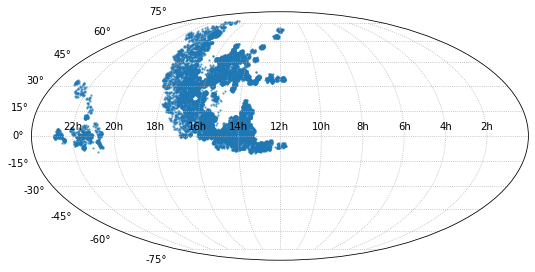

In [35]:
fig = plot_radec(tguad['TARGET_RA'], tguad['TARGET_DEC'])

In [36]:
# All targets
_ids_all, _counts_all = np.unique(tguad['SGA_ID'], return_counts=True)

# All targets with decent redshifts
isgoodz = (tguad['ZWARN']==0) & (tguad['DELTACHI2']>=25)
_ids_goodz, _counts_goodz = np.unique(tguad['SGA_ID'][isgoodz], return_counts=True)
_ids_goodz[_counts_goodz > 1]

22240
26839
36408
81410
81587
87500
97758
101426
103331
125443
126180


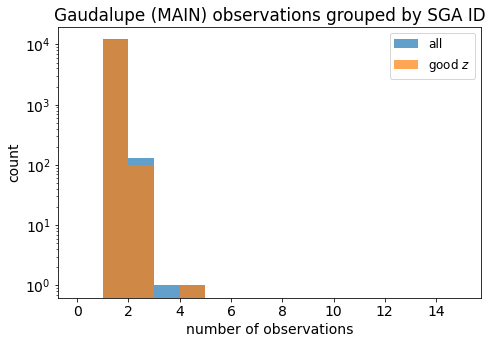

In [37]:
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)
ax.hist(_counts_all, bins=np.arange(0,16), alpha=0.7, log=True, label='all')
ax.hist(_counts_goodz, bins=np.arange(0,16), alpha=0.7, log=True, label='good $z$')
ax.set(xlabel='number of observations',
       ylabel='count',
       title='Gaudalupe (MAIN) observations grouped by SGA ID')
ax.legend(fontsize=12, loc='upper right');

In [38]:
select = np.in1d(tguad['SGA_ID'], _ids_goodz[_counts_goodz > 1]) & isgoodz
tguad_tf = tguad[select].group_by('SGA_ID')
tguad_tf

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes7,float64,float64,int64,float64,bytes76,bytes3,int64,float64,float64
2402837711552513,236.448286008377,4.73198655273865,31450,main,0.0414270250857592,4.61389588320269e-06,0,1601.04414309189,guadalupe/healpix/main/dark/314/31450/redrock-main-dark-31450.fits,TFT,22240,236.44828600837715,4.731986552738649
39627903381537703,236.448268956796,4.73054191044664,31450,main,0.0417363074592073,3.36117906450596e-06,0,3829.62446111441,guadalupe/healpix/main/bright/314/31450/redrock-main-bright-31450.fits,TFT,22240,236.4482689567962,4.730541910446642
2403191257825288,239.552234108625,19.7653140227445,8550,main,0.066728415056766,3.23568374138166e-06,0,3974.3466373086,guadalupe/healpix/main/dark/85/8550/redrock-main-dark-8550.fits,TFT,26839,239.55223410862453,19.765314022744494
39628256927813187,239.555007699263,19.7666692309552,8550,main,0.0660522639483845,2.00948975871332e-05,0,1709.24572459632,guadalupe/healpix/main/bright/85/8550/redrock-main-bright-8550.fits,TFT,26839,239.55500769926263,19.76666923095519
2403330714238978,254.066457726246,26.0329397878601,9281,main,0.0459880623709344,4.93573561399561e-06,0,1131.43369889259,guadalupe/healpix/main/dark/92/9281/redrock-main-dark-9281.fits,TFT,36408,254.06645772624626,26.032939787860077
39628396384227409,254.065576490327,26.0297671503843,9281,main,0.0465251064200452,7.43022960867574e-06,0,2510.3432854414,guadalupe/healpix/main/bright/92/9281/redrock-main-bright-9281.fits,TFT,36408,254.0655764903268,26.02976715038427
2402741125120000,235.477362091607,0.708418814662338,31426,main,0.0067910454971914,6.32743868826792e-06,0,561.534598083701,guadalupe/healpix/main/dark/314/31426/redrock-main-dark-31426.fits,TFT,81410,235.47736209160738,0.708418814662338
39627806795109984,235.498540279925,0.71315826533912,31426,main,0.00641762485086946,4.5594676613852e-06,0,2409.76344516268,guadalupe/healpix/main/bright/314/31426/redrock-main-bright-31426.fits,TFT,81410,235.4985402799251,0.7131582653391201
2402867767934978,234.391654760289,5.98796914487098,31469,main,0.00459842126995215,2.13649959513157e-05,0,192.278564359192,guadalupe/healpix/main/dark/314/31469/redrock-main-dark-31469.fits,TFT,81587,234.3916547602889,5.987969144870983


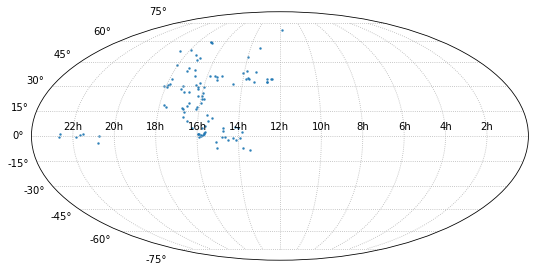

In [39]:
fig = plot_radec(tguad_tf['TARGET_RA'], tguad_tf['TARGET_DEC'])

### Loop through Observations of SGA Objects

  0%|          | 0/102 [00:00<?, ?it/s]

No MAIN (SGA) target for 81587?
No MAIN (SGA) target for 187548?
No MAIN (SGA) target for 265856?
No MAIN (SGA) target for 977015?
No MAIN (SGA) target for 1066579?
No MAIN (SGA) target for 1293610?
No MAIN (SGA) target for 1397114?


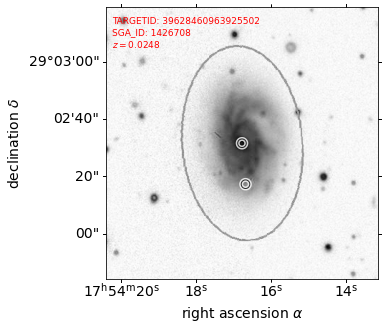

In [17]:
sga_ids = np.unique(tguad_tf['SGA_ID'])
N = len(sga_ids)

with tqdm_notebook(total=N) as progress_bar:
    for i, sga_id in enumerate(sga_ids):
        progress_bar.update(1)
        
        tab = tguad_tf[tguad_tf['SGA_ID']==sga_id]

        # Grab TARGETIDs starting with 3, which is probably the MAIN (SGA) target.
        digits = firstdigit(tab['TARGETID'])
        if np.any(digits == 3):
            maintargetids = np.unique(tab['TARGETID'][digits==3].value)
        else:
            print(f'No MAIN (SGA) target for {sga_id}?')
            continue

        # For now, just grab the first TARGETID in the list that is assumed to be the galaxy center
        maintargetid = maintargetids[0]
        mainobs = tab[tab['TARGETID']==maintargetid][0]
        ra, dec, z = [mainobs[_] for _ in ['RA', 'DEC', 'Z']]

        # Download the corresponding image file.
        npix=380
        img_file, img_wcs = get_cutout(maintargetid, ra=ra, dec=dec, width=npix, height=npix, verbose=False)
        img = plt.imread(img_file)
        img = img[:, :, :3].mean(axis=2)

        # Draw the object and the positions of all observations.
        fig = plt.figure(num=1, figsize=(6.5,5), clear=True)
        ax1 = fig.add_subplot(111, projection=img_wcs)
        ax1.imshow(np.flip(img**1.7, axis=0), cmap='gray_r')
        ax1.set(xlabel=r'right ascension $\alpha$',
                ylabel=r'declination $\delta$')
        ax1.text(int(0.02*npix), int(0.85*npix),
                 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(maintargetid, sga_id, z),
                 fontsize=9,
                 color='red')

        for obs in tab:
            ra, dec = [obs[_] for _ in ['RA', 'DEC']]
            for color, lw in zip(['white', 'black'], [4, 1]):
                r = SphericalCircle((ra*u.deg, dec*u.deg), 1.5*u.arcsec,
                                 edgecolor=color, facecolor='none', alpha=0.8, lw=lw, ls='-',
                                 transform=ax1.get_transform('icrs'))
                ax1.add_patch(r)

        fig.savefig(f'_cache/pv_tv_guadalupe_{maintargetid}.png', dpi=120)

## Check MAIN Survey PV TF Targets against Daily Reduction

DESI Y1: 20210514 - 20220514.

In [82]:
tdaily = Table.read('desi_pv_tf_daily_tiles.fits')
tdaily = unique(tdaily[(tdaily['NIGHT'] > 20210513) & (tdaily['NIGHT'] < 20220514)])
tdaily

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64
-411444222,156.21815002209,7.15848284808457,41144,20220504,0.102479475013216,8.66839004506941e-05,2053,0.394602766493335,daily/tiles/cumulative/41144/20220504/redrock-4-41144-thru20220504.fits,TFT,4614,156.21810707253144,7.1582430702316175
-256075243,267.712765090224,29.4851124724098,25607,20220504,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/25607/20220504/redrock-5-25607-thru20220504.fits,SGA,447725,267.7127798938763,29.484990855307803
-255474428,318.116492659747,-5.28401899381209,25547,20211021,-0.00199569129234795,4.13114935733491e-48,1570,1.94266889222573e+84,daily/tiles/cumulative/25547/20211021/redrock-4-25547-thru20211021.fits,TFT,342501,318.1167585749797,-5.283990383719008
-236269010,159.441551301486,11.8164401561333,23626,20220103,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/23626/20220103/redrock-9-23626-thru20220103.fits,SGA,112426,159.44167440686755,11.816368587372878
-220511122,158.609359755658,4.10129785830121,22051,20220420,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/22051/20220420/redrock-1-22051-thru20220420.fits,TFT,1285714,158.60939980220817,4.1014249139344905
-215282046,135.381709169741,2.89942982211333,21528,20220307,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/21528/20220307/redrock-2-21528-thru20220307.fits,TFT,730406,135.38157955417336,2.8996065765603865
-215264164,139.654305794728,0.327220629540815,21526,20220125,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/21526/20220125/redrock-4-21526-thru20220125.fits,SGA,460051,139.65430588469135,0.32746260142544686
-204834222,156.218107863433,7.15848293358231,20483,20220423,-0.00199570145091582,4.13115987161332e-48,1570,1.94266889222573e+84,daily/tiles/cumulative/20483/20220423/redrock-4-20483-thru20220423.fits,TFT,4614,156.21810707253144,7.1582430702316175
-115015155,187.763020229623,0.048940228168639,11501,20220209,-0.00199570145091582,4.13115987161332e-48,3618,1.94266889222573e+84,daily/tiles/cumulative/11501/20220209/redrock-5-11501-thru20220209.fits,TFT,1202979,187.7631083263793,0.04896332744150247


In [83]:
np.unique(tdaily['SGA_ID'])

38
53
55
66
72
74
79
94
117
121
136


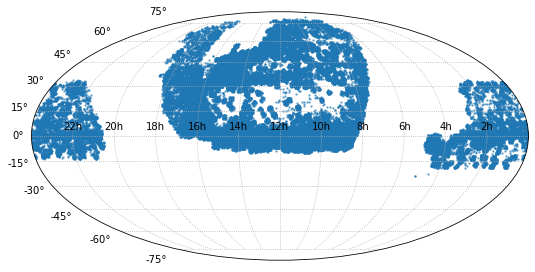

In [84]:
fig = plot_radec(tdaily['TARGET_RA'], tdaily['TARGET_DEC'])

In [85]:
# All targets
_ids_all, _counts_all = np.unique(tdaily['SGA_ID'], return_counts=True)

# All targets with decent redshifts
isgoodz = (tdaily['ZWARN']==0) & (tdaily['DELTACHI2']>=25)
_ids_goodz, _counts_goodz = np.unique(tdaily['SGA_ID'][isgoodz], return_counts=True)
_ids_goodz[_counts_goodz > 1]

55
94
117
223
242
425
454
581
731
783
1135


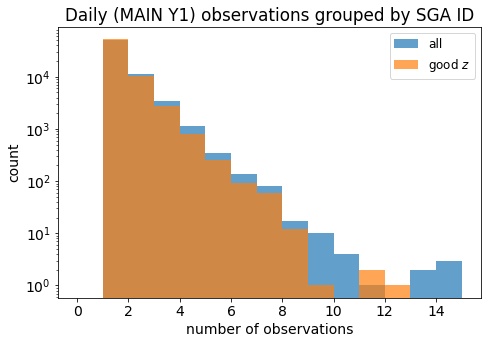

In [86]:
fig, ax = plt.subplots(1,1, figsize=(7,5), tight_layout=True)
ax.hist(_counts_all, bins=np.arange(0,16), alpha=0.7, log=True, label='all')
ax.hist(_counts_goodz, bins=np.arange(0,16), alpha=0.7, log=True, label='good $z$')
ax.set(xlabel='number of observations',
       ylabel='count',
       title='Daily (MAIN Y1) observations grouped by SGA ID')
ax.legend(fontsize=12, loc='upper right');

### Clean up Daily Tiles Observations

Extract observations with a MAIN survey central target and at least 2 unique TARGETIDs per SGA_ID.

In [114]:
select = np.in1d(tdaily['SGA_ID'], _ids_goodz[_counts_goodz > 1]) & isgoodz
tdaily_tf = tdaily[select].group_by('SGA_ID')

tmain_tf = None

# Loop through the table and keep only SGA IDs with >= 2 unique TARGETIDs, where one is a MAIN survey target.
sga_ids = np.unique(tdaily_tf['SGA_ID'])
N = len(sga_ids)

with tqdm_notebook(total=N) as progress_bar:
    for i, sga_id in enumerate(sga_ids):
        progress_bar.update(1)
        tab = tdaily_tf[tdaily_tf['SGA_ID']==sga_id]

        # MAIN targets have a TARGETID that starts with 3. Ensure one is present.
        digits = firstdigit(tab['TARGETID'])
        if np.any(digits == 3):
            maintargetids = np.unique(tab['TARGETID'][digits==3].value)

            # Ensure there are at least two distinct TARGETIDs matched to this SGA_ID.
            ntargets = len(np.unique(tab['TARGETID'].value))
            if ntargets >= 2:

                # Ensure the TARGETIDs correspond to distinct locations on the sky.
                coords = SkyCoord(tab['TARGET_RA'], tab['TARGET_DEC'], frame='icrs', unit='degree')
                is_distinct = np.any([c1.separation(c2).to_value('arcsec') > 1 for c1 in coords for c2 in coords])
                if not is_distinct:
                    continue
            # Check that there two or more TARGETIDs.
            else:
                continue
        # Check that there is a MAIN survey TARGETID associated with this SGA_ID.
        else:
            continue

        if tmain_tf is None:
            tmain_tf = tab
        else:
            tmain_tf = vstack([tmain_tf, tab])

tmain_tf

  0%|          | 0/14293 [00:00<?, ?it/s]

TARGETID,TARGET_RA,TARGET_DEC,TILEID,NIGHT,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,int64,float64,float64,int64,float64,bytes71,bytes3,int64,float64,float64
2389570544992261,199.730072385194,1.72783181582658,24243,20220423,0.0437435626710041,2.3020377661851e-05,0,48.0715520321392,daily/tiles/cumulative/24243/20220423/redrock-5-24243-thru20220423.fits,TFT,55,199.73007238519418,1.7278318158265755
2389570544992261,199.730072385194,1.72783181582658,25837,20220430,0.043713446980999,2.98109984300264e-05,0,36.9368270919658,daily/tiles/cumulative/25837/20220430/redrock-3-25837-thru20220430.fits,TFT,55,199.73007238519418,1.7278318158265755
2389570544992262,199.731168566683,1.72471420712763,22682,20220508,0.0442277198032649,4.91740023312067e-06,0,1010.09990862012,daily/tiles/cumulative/22682/20220508/redrock-8-22682-thru20220508.fits,TFT,55,199.7311685666833,1.7247142071276316
39627830354515481,199.730620476388,1.72627301155604,21127,20210605,0.0439989254838724,1.09173725646285e-05,0,285.64377264207,daily/tiles/cumulative/21127/20210605/zbest-0-21127-thru20210605.fits,TFT,55,199.73062047638814,1.7262730115560398
2389593684967425,138.936887947814,2.69359099571864,26214,20220305,0.0894203282762809,1.03257031947133e-05,0,299.505344927311,daily/tiles/cumulative/26214/20220305/redrock-0-26214-thru20220305.fits,TFT,117,138.9368879478137,2.6935909957186372
39627853494489271,138.935401881933,2.69476220880469,23090,20220112,0.0900412948562097,2.87560583699443e-05,0,884.744120200397,daily/tiles/cumulative/23090/20220112/redrock-6-23090-thru20220112.fits,TFT,117,138.9354018819327,2.69476220880469
2390308285317127,197.788671878468,34.1699112536563,24300,20220221,0.0342437776882019,1.24252670967763e-05,0,114.676442600787,daily/tiles/cumulative/24300/20220221/redrock-2-24300-thru20220221.fits,TFT,223,197.78867187846762,34.16991125365625
39632966141349468,197.787014056547,34.171253677203,25870,20220107,0.0340258986446975,7.92210227932365e-06,0,573.508448885899,daily/tiles/cumulative/25870/20220107/redrock-3-25870-thru20220107.fits,TFT,223,197.78701405654667,34.171253677203055
2389978080346113,118.856456640878,18.9760695714997,22955,20211226,0.0428118152378448,2.35624567778664e-05,0,69.9700332144275,daily/tiles/cumulative/22955/20211226/redrock-6-22955-thru20211226.fits,TFT,581,118.85645664087838,18.97606957149971


In [115]:
# All targets
_ids_all, _counts_all = np.unique(tmain_tf['SGA_ID'], return_counts=True)

# All targets with decent redshifts
isgoodz = (tmain_tf['ZWARN']==0) & (tmain_tf['DELTACHI2']>=25)
_ids_goodz, _counts_goodz = np.unique(tmain_tf['SGA_ID'][isgoodz], return_counts=True)
_ids_goodz[_counts_goodz > 1]

55
117
223
581
731
1135
1158
1287
1289
1358
1663


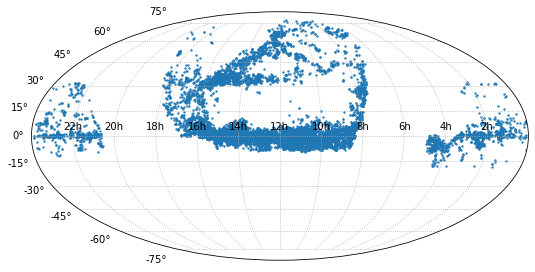

In [116]:
fig = plot_radec(tmain_tf['TARGET_RA'], tmain_tf['TARGET_DEC'])

### Loop through Observations of SGA Objects

  0%|          | 0/8243 [00:00<?, ?it/s]

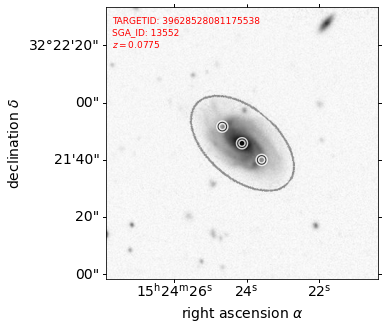

In [117]:
sga_ids = np.unique(tmain_tf['SGA_ID'])
N = len(sga_ids)

with tqdm_notebook(total=N) as progress_bar:
    for i, sga_id in enumerate(sga_ids):
        progress_bar.update(1)
        
        tab = tmain_tf[tmain_tf['SGA_ID']==sga_id]

        # Grab TARGETIDs starting with 3, which is probably the MAIN (SGA) target.
        digits = firstdigit(tab['TARGETID'])
        if np.any(digits == 3):
            maintargetids = np.unique(tab['TARGETID'][digits==3].value)
        else:
            print(f'No MAIN (SGA) target for {sga_id}?')
            continue

        # For now, just grab the first TARGETID in the list that is assumed to be the galaxy center
        maintargetid = maintargetids[0]
        mainobs = tab[tab['TARGETID']==maintargetid][0]
        ra, dec, z = [mainobs[_] for _ in ['RA', 'DEC', 'Z']]

        # Download the corresponding image file.
        npix=380
        img_file, img_wcs = get_cutout(maintargetid, ra=ra, dec=dec, width=npix, height=npix, verbose=False)
        img = plt.imread(img_file)
        img = img[:, :, :3].mean(axis=2)

        # Draw the object and the positions of all observations.
        fig = plt.figure(num=1, figsize=(6.5,5), clear=True)
        ax1 = fig.add_subplot(111, projection=img_wcs)
        ax1.imshow(np.flip(img**1.7, axis=0), cmap='gray_r')
        ax1.set(xlabel=r'right ascension $\alpha$',
                ylabel=r'declination $\delta$')
        ax1.text(int(0.02*npix), int(0.85*npix),
                 'TARGETID: {}\nSGA_ID: {}\n$z={{{:.4f}}}$'.format(maintargetid, sga_id, z),
                 fontsize=9,
                 color='red')

        for obs in tab:
            ra, dec = [obs[_] for _ in ['RA', 'DEC']]
            for color, lw in zip(['white', 'black'], [4, 1]):
                r = SphericalCircle((ra*u.deg, dec*u.deg), 1.5*u.arcsec,
                                 edgecolor=color, facecolor='none', alpha=0.8, lw=lw, ls='-',
                                 transform=ax1.get_transform('icrs'))
                ax1.add_patch(r)

        fig.savefig(f'_cache/pv_tv_y1main_{maintargetid}.png', dpi=120)
        
        if i > 100:
            break